# Vision transformers for glioma classifications using T1 magnetic resonance images

**Description:** Implementing the Vision Transformer (ViT) model for image classification.

## Setup

Link with Google Drive and initial configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
!pip install tensorflow-addons
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import glob
import os
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Prepare the data

In [ ]:
import seaborn as sns

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Pretraining
*************************************************************************

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


********************************************************************************

## Configure the hyperparameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 10
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


## Use data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
#data_augmentation.layers[0].adapt(x_train)


## Implement multilayer perceptron (MLP)

In [ ]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [ ]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 32 X 32
Patch size: 16 X 16
Patches per image: 4
Elements per patch: 768


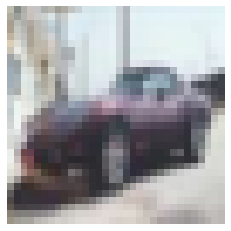

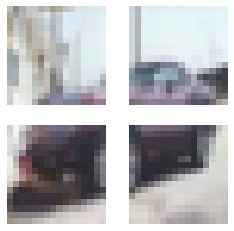

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [ ]:

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.


In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/EE657 Research/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, test_accuracy, test_top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(test_top_5_accuracy * 100, 2)}%")
    monitor="Test accuracy"

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
176/176 [==============================] - 184s 744ms/step - loss: 2.0210 - accuracy: 0.2679 - top-5-accuracy: 0.7696 - val_loss: 1.7604 - val_accuracy: 0.3556 - val_top-5-accuracy: 0.8638
Epoch 2/100
176/176 [==============================] - 127s 723ms/step - loss: 1.7816 - accuracy: 0.3576 - top-5-accuracy: 0.8570 - val_loss: 1.6018 - val_accuracy: 0.4266 - val_top-5-accuracy: 0.8920
Epoch 3/100
176/176 [==============================] - 129s 731ms/step - loss: 1.7027 - accuracy: 0.3846 - top-5-accuracy: 0.8736 - val_loss: 1.6162 - val_accuracy: 0.4300 - val_top-5-accuracy: 0.8892
Epoch 4/100
176/176 [==============================] - 130s 735ms/step - loss: 1.6551 - accuracy: 0.4049 - top-5-accuracy: 0.8838 - val_loss: 1.4918 - val_accuracy: 0.4594 - val_top-5-accuracy: 0.9118
Epoch 5/100
176/176 [==============================] - 127s 722ms/step - loss: 1.6234 - accuracy: 0.4173 - top-5-accuracy: 0.8896 - val_loss: 1.4277 - val_accuracy: 0.4778 - val_top-5-accuracy: 0.

In [ ]:
# Loads the weights
vit_classifier.load_weights("/content/drive/MyDrive/EE657 Research/")

# Re-evaluate the model
loss, acc, test_top_5_accuracy  = vit_classifier.evaluate(x_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))



313/313 - 24s - loss: 0.7299 - accuracy: 0.7477 - top-5-accuracy: 0.9816 - 24s/epoch - 77ms/step
Restored model, accuracy: 74.77%


In [ ]:
vit_classifier.save('/content/drive/MyDrive/EE657 Research')

In [ ]:
vit_classifier.weights

[<tf.Variable 'normalization/mean:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'normalization/variance:0' shape=(3,) dtype=float32, numpy=array([1., 1., 1.], dtype=float32)>,
 <tf.Variable 'normalization/count:0' shape=() dtype=int64, numpy=0>,
 <tf.Variable 'patch_encoder/dense/kernel:0' shape=(108, 64) dtype=float32, numpy=
 array([[ 0.00287337, -0.03132305,  0.03027878, ...,  0.02710093,
         -0.02268706, -0.02867016],
        [-0.06894591, -0.02313006, -0.0345585 , ...,  0.04828267,
         -0.0534496 ,  0.03053654],
        [ 0.05625594, -0.03386092, -0.02224148, ...,  0.01824228,
         -0.03324592,  0.0283245 ],
        ...,
        [-0.0235562 ,  0.02784057, -0.00267186, ...,  0.07349598,
          0.06233595, -0.02925927],
        [ 0.08524869,  0.01831382, -0.02325699, ..., -0.07693785,
          0.06262045,  0.03463969],
        [ 0.03702745,  0.06839412,  0.03732042, ..., -0.07491968,
          0.03038211,  0.00455681]], dtype

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: ignored

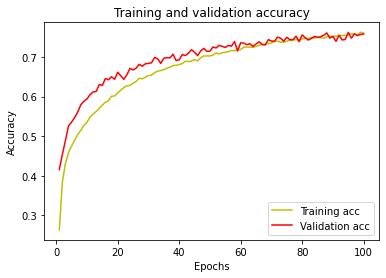

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Fine tunning

In [ ]:
print(os.listdir("/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair"))

['Train', 'Test', '.ipynb_checkpoints', 'Test_3', 'Train_3', 'Train_4', 'Train_5', 'Train_6', 'Train_7']


In [ ]:
SIZE = 32

In [ ]:
train_images = []
train_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/*"):
    label = directory_path.split("/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

HGG
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_80_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_81_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_82_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_83_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_84_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_85_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_86_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_87_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_88_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train/HGG/P006_89_T2F_HGG_T.png
/content/drive/MyDrive/EE657 Researc

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
test_images = []
test_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Test/*"):
    fruit_label = directory_path.split("/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Test/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

In [ ]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [ ]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
num_classes = 3
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
#x_train='/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Train'
#x_test = '/content/drive/MyDrive/EE657 Research/BRATS Images/All_T2_Flair/Test'
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (4490, 32, 32, 3) - y_train shape: (4490,)
x_test shape: (1962, 32, 32, 3) - y_test shape: (1962,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 3
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


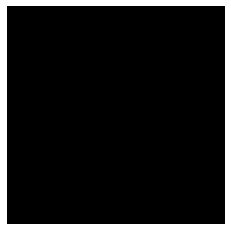

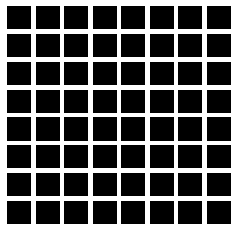

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/MyDrive/EE657 Research/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
16/16 [==============================] - 88s 5s/step - loss: 4.0116 - accuracy: 0.3638 - top-5-accuracy: 1.0000 - val_loss: 1.7820 - val_accuracy: 0.0401 - val_top-5-accuracy: 1.0000
Epoch 2/100
16/16 [==============================] - 72s 5s/step - loss: 1.0837 - accuracy: 0.4417 - top-5-accuracy: 1.0000 - val_loss: 1.5699 - val_accuracy: 0.1247 - val_top-5-accuracy: 1.0000
Epoch 3/100
16/16 [==============================] - 70s 4s/step - loss: 1.0172 - accuracy: 0.4826 - top-5-accuracy: 1.0000 - val_loss: 1.0916 - val_accuracy: 0.3719 - val_top-5-accuracy: 1.0000
Epoch 4/100
16/16 [==============================] - 71s 4s/step - loss: 0.9770 - accuracy: 0.4895 - top-5-accuracy: 1.0000 - val_loss: 1.1021 - val_accuracy: 0.3586 - val_top-5-accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 70s 4s/step - loss: 0.9653 - accuracy: 0.4873 - top-5-accuracy: 1.0000 - val_loss: 1.1921 - val_accuracy: 0.2205 - val_top-5-accuracy: 1.0000
Epoch 6/100
16/16 [======

Plot

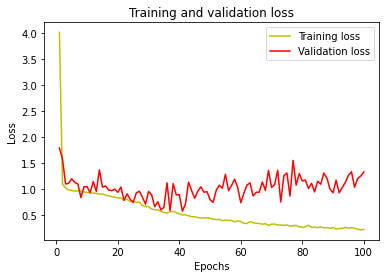

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

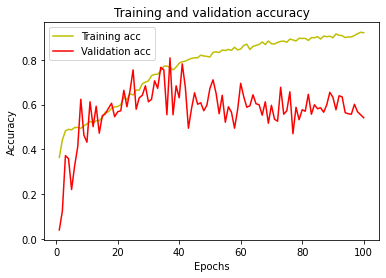

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, 'y', label='Training acc')
plt.plot(epochs, val_accuracy, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
prediction_NN = vit_classifier.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

In [ ]:
true_NN= test_labels
#true_NN=np.argmax(true_NN, axis=-1)
#true_NN=le.inverse_transform(true_NN)

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction_NN)

In [ ]:
def plot_confusion_matrix(cm, num_classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(num_classes))
    plt.xticks(tick_marks, num_classes, rotation=45)
    plt.yticks(tick_marks, num_classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['HGG','LGG', 'No Tumor']

Confusion matrix, without normalization
[[335 129  90]
 [236 183 194]
 [ 28  45 722]]


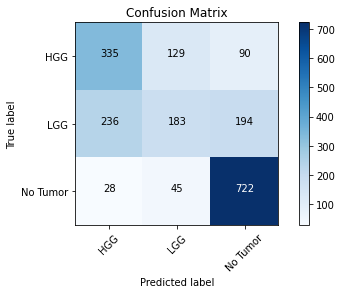

In [ ]:
plot_confusion_matrix(cm=cm, num_classes=cm_plot_labels, title='Confusion Matrix')

The prediction for this image is:  ['No_Tumor']
The actual label for this image is:  LGG


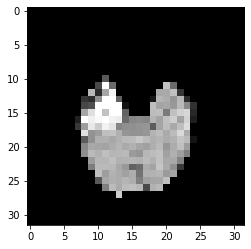

In [ ]:
#Check results on a few select images

#n=5 dog park. NN not as good as RF.
n=150  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(vit_classifier.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])
